Thanks to https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('crowd_change.csv', engine='python')

# interpolation for "Time"
df['Time'] = pd.to_datetime(df['Time'], yearfirst=True)
for dd in df['Time'].index:
  if dd%2 == 1:
    df['Time'].iloc[dd] = df['Time'].iloc[dd] + pd.DateOffset(minutes=15)

timeseries = df[["Current Total Count"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device=}.')

<ipython-input-130-2421bfddb117>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'].iloc[dd] = df['Time'].iloc[dd] + pd.DateOffset(minutes=15)


Using device=device(type='cuda', index=0).


In [ ]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
class simpleLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = simpleLSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=256)

model.to(device)

simpleLSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
hist_loss, hist_train_rmse, hist_test_rmse = ([] for i in range(3))
n_epochs = 1000
for epoch in range(n_epochs):
  model.train()
  for X_batch, y_batch in loader:
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hist_loss.append(loss.item())
  # Validation
  if epoch % 10 != 0:
    continue
  model.eval()
  with torch.no_grad():
    y_pred = model(X_train)
    train_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_train.cpu()))
    y_pred = model(X_test)
    test_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_test.cpu()))
    hist_train_rmse.append(train_rmse)
    hist_test_rmse.append(test_rmse)
  print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 20.2010, test RMSE 25.0987
Epoch 10: train RMSE 13.2123, test RMSE 17.8912
Epoch 20: train RMSE 10.1529, test RMSE 14.3226
Epoch 30: train RMSE 7.9586, test RMSE 11.6795
Epoch 40: train RMSE 6.8785, test RMSE 10.1014
Epoch 50: train RMSE 6.2757, test RMSE 9.0987
Epoch 60: train RMSE 5.9170, test RMSE 8.4462
Epoch 70: train RMSE 5.6766, test RMSE 7.9735
Epoch 80: train RMSE 5.4935, test RMSE 7.6220
Epoch 90: train RMSE 5.3570, test RMSE 7.3532
Epoch 100: train RMSE 5.2593, test RMSE 7.1438
Epoch 110: train RMSE 5.1834, test RMSE 6.9821
Epoch 120: train RMSE 5.1145, test RMSE 6.8373
Epoch 130: train RMSE 5.0673, test RMSE 6.7246
Epoch 140: train RMSE 5.0211, test RMSE 6.6259
Epoch 150: train RMSE 4.9906, test RMSE 6.5739
Epoch 160: train RMSE 4.9572, test RMSE 6.5072
Epoch 170: train RMSE 4.9401, test RMSE 6.4653
Epoch 180: train RMSE 4.9216, test RMSE 6.4218
Epoch 190: train RMSE 4.9121, test RMSE 6.4098
Epoch 200: train RMSE 4.8820, test RMSE 6.3614
Epoch 210: train

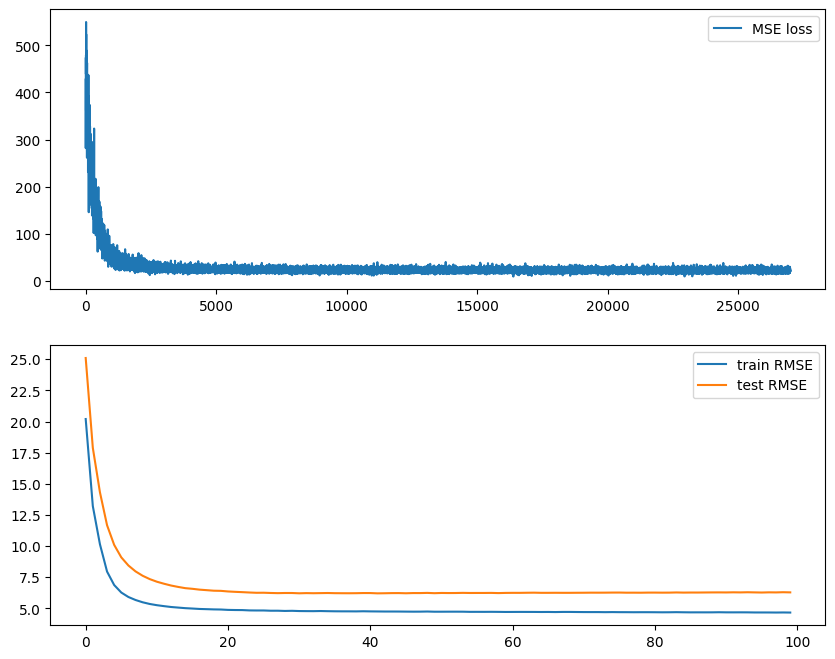

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(10, 8))
axes[0].plot(hist_loss)
axes[0].legend(['MSE loss'])
axes[1].plot(hist_train_rmse, label='train RMSE')
axes[1].plot(hist_test_rmse, label='test RMSE')
axes[1].legend()
plt.show()

In [ ]:
with torch.no_grad():
  dd = model(X_test.cpu())
# plt.plot(dd[:, -1, :])
# dd[:, -1, :].shape
plt.plot(dd[:, 0, :])
plt.plot(dd[:, 1, :])
plt.plot(dd[:, 2, :])
plt.plot(dd[:, 3, :])

In [ ]:
with torch.no_grad():
    model.cpu()
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train.cpu())
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train.cpu())[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    # test_plot[train_size+lookback:len(timeseries)] = model(X_test.cpu())[:, -1, :]
    test_plot[train_size+lookback:len(timeseries)] = model(X_test.cpu())[:, -1, :]


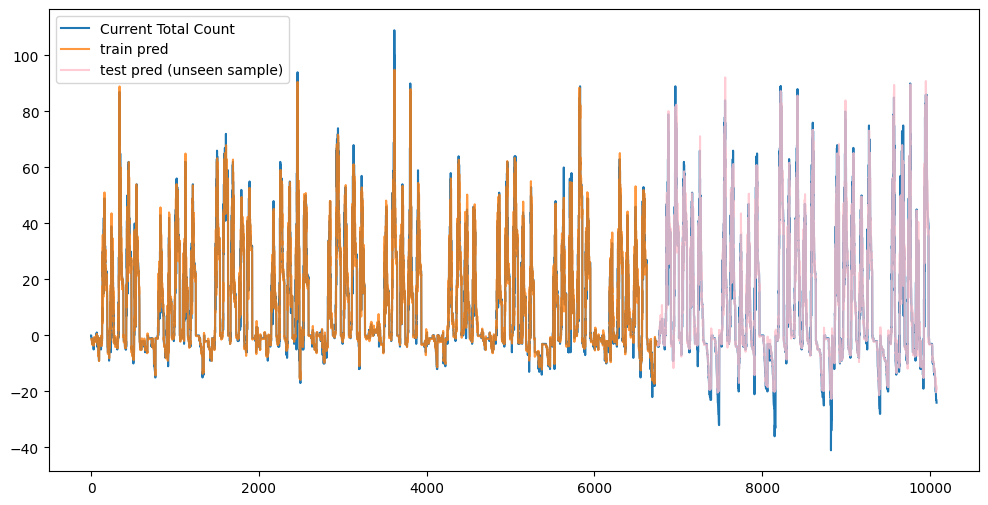

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(timeseries, label='Current Total Count')
ax.plot(train_plot,  label='train pred', alpha=.8)
ax.plot(test_plot, c='pink', label='test pred (unseen sample)', alpha=.8)

# ax.set_xticklabels(df['Time'])
# plt.xticks(rotation=30)
ax.legend()
plt.show()

---


# Seq2Seq 有BUG

In [ ]:
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('crowd_change.csv', engine='python')

# interpolation for "Time"
df['Time'] = pd.to_datetime(df['Time'], yearfirst=True)
for dd in df['Time'].index:
  if dd%2 == 1:
    df['Time'].iloc[dd] = df['Time'].iloc[dd] + pd.DateOffset(minutes=15)

timeseries = df[["Current Total Count"]].values.astype('float32')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device=}.')
train_ratio = 0.7
n_past = 20

<ipython-input-105-9897ba55f9bc>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'].iloc[dd] = df['Time'].iloc[dd] + pd.DateOffset(minutes=15)


Using device=device(type='cuda', index=0).


In [ ]:
def preprocess(data_trend, train_ratio, n_past):

    scaler = StandardScaler()
    data_trend = scaler.fit_transform(data_trend)

    train_ind = int(len(data_trend)*train_ratio)
    train_data = data_trend[:train_ind]
    val_data = data_trend[train_ind:]

    # convert our train data into a pytorch tensor
    X_train, Y_train = create_sequences(train_data, n_past)
    X_val, Y_val = create_sequences(val_data, n_past)

    return X_train, Y_train, X_val, Y_val, scaler


def create_sequences(data, n_past):
    X,Y = [],[]
    L = len(data)
    # for i in range(L-(n_past+5)):
    for i in range(L-(n_past+2)):
        X.append(data[i:i+n_past])
        # Y.append(data[i+n_past:i+n_past+5][:,3])
        Y.append(data[i+n_past:i+n_past+2][:, 0])  # 這裡原本是交易量的樣子，改成人數(0)
        # Y.append(data[i+n_past:i+n_past+5][:, 0])  # 這裡原本是交易量的樣子，改成人數(0)

    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Time', 'Adj Close']]].values
X_train, Y_train, X_val, Y_val, scaler = preprocess(data, train_ratio, n_past)

batch_size = 128#32
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

print(X_train.shape) # torch.Size([624, 20, 5])
print(Y_train.shape) # torch.Size([624, 5])

torch.Size([7034, 20, 2])
torch.Size([7034, 2])


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size=5, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size, hidden_size, n_layers)

    def forward(self, x):
        # x: input batch data, size: [input_seq_len, batch_size, feature_size]
        output, (hidden, cell) = self.lstm(x)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_size=5, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(output_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        """
        x size = [batch_size, feature_size]
        --> x only has two dimensions since the input is batch of last coordinate of observed trajectory
        so the sequence length has been removed.
        """
        # add sequence dimension to x, to allow use of nn.LSTM
        x = x.unsqueeze(0)  # -->[1, batch_size, feature_size]

        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.linear(output)

        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, teacher_forcing_ratio=0.5):
        # print(f'[DEBUG] {x.shape=}')
        x = x.permute(1,0,2) #我們的 dataloader是 [batch, seq, dim]
        # print(f'[DEBUG] {y.shape=}')
        # y = y.permute(1,0,2) #但為了方便操作LSTM，直接把它擺成[seq,batch,dim]，output再把它擺回來
        y = y.permute(1,0) #但為了方便操作LSTM，直接把它擺成[seq,batch,dim]，output再把它擺回來
        """
        x = [input_seq_len, batch_size, feature_size]
        y = [target_seq_len, batch_size, feature_size]
        """
        batch_size = x.shape[1]
        target_len = y.shape[0]

        # tensor to store decoder outputs of each time step
        outputs = torch.zeros(y.shape).to(self.device)

        hidden, cell = self.encoder(x)
        decoder_input = x[-1, :, :] # first input to decoder is last of x

        for i in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            # place predictions in a tensor holding predictions for each time step
            # print(f'{output[-1, -1, :].shape = }')
            # print(f'{output[-1, :, :].shape = }')
            print(f'{output[-1, -1, :] = }')
            print(f'{output[-1, :, :] = }')
            # print(f'{i = }')
            print(f'{output = }')
            print(f'{outputs = }')
            print(f'{outputs[i] = }')
            print(f'{outputs[:, i] = }')
            # outputs[i] = torch.squeeze(output[-1, -1, :], 0)
            # outputs[i] = torch.squeeze(output[-1, :, :], 0)
            # outputs[i] = torch.squeeze(output, 0)
            # outputs[:, i] = output[-1, -1, :]
            outputs[i] = output[-1, -1, :]

            teacher_forcing = random.random() < teacher_forcing_ratio
            # output is the same shape as decorder input-->[batch_size, feature_size]
            # so we use output directly as input or use true lable depending on teacher_forcing flag
            decoder_input = y[i] if teacher_forcing else torch.squeeze(output,0)

        # return outputs.permute(1,0,2)
        return outputs.permute(1,0)


myEncoder = Encoder(input_size=2, embedding_size=36, hidden_size=128, n_layers=2, dropout=0.3)
myDecoder = Decoder(output_size=2, embedding_size=36, hidden_size=128, n_layers=2, dropout=0.3)

model = Seq2Seq(myEncoder, myDecoder, device)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(2, 128, num_layers=2)
  )
  (decoder): Decoder(
    (lstm): LSTM(2, 128, num_layers=2)
    (linear): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [ ]:
close_price_true = []
close_price_pred = []

dim = 1#3
for i in range(len(val_set)):
    x,y = val_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pseudo_y = torch.ones(y.shape)
    pred = model(x.to(device), pseudo_y.to(device), teacher_forcing_ratio=0)

    # close_price_true.append(scaler.inverse_transform(y)[0,0,dim].item())
    close_price_true.append(scaler.inverse_transform(y)[0,dim].item())
    close_price_pred.append(scaler.inverse_transform(pred.detach().cpu().numpy())[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])

output[-1, -1, :] = tensor([-0.0782, -0.0997], device='cuda:0', grad_fn=<SliceBackward0>)
output[-1, :, :] = tensor([[-0.0782, -0.0997]], device='cuda:0', grad_fn=<SliceBackward0>)
output = tensor([[[-0.0782, -0.0997]]], device='cuda:0', grad_fn=<ViewBackward0>)
outputs = tensor([[0.],
        [0.]], device='cuda:0')
outputs[i] = tensor([0.], device='cuda:0')
outputs[:, i] = tensor([0., 0.], device='cuda:0')


RuntimeError: ignored

In [ ]:
# ss = torch.tensor([[[-0.0782, -0.0997]]])
ss = torch.tensor([[-0.0782, -0.0997]])
print(f'{ss.shape = }')
print(f'{ss = }')
print(torch.squeeze(ss, 0).shape)
print(torch.squeeze(ss, 0))

ss.shape = torch.Size([1, 2])
ss = tensor([[-0.0782, -0.0997]])
torch.Size([2])
tensor([-0.0782, -0.0997])
